# Twitter Sentiment Analysis

In [74]:
%%capture
!pip install pandas
!pip install tweet-preprocessor
!pip install seaborn

import json
import base64
import requests
import urllib
import pandas as pd
import seaborn as sns

## Authentication and Grabbing Twitter Data

In [2]:
base_url = 'https://api.twitter.com'
auth_url = f'{base_url}/oauth2/token'
f = open('.twitter_keys', 'r')
auth = json.load(f)
f.close()

bearer_token = auth['Bearer_Token']

In [3]:
headers = {"Authorization": "Bearer {}".format(bearer_token)}


In [4]:
def search_recent_tweets(keywords, headers):

    search_url = "https://api.twitter.com/2/tweets/search/recent"
    search_resp = requests.request("GET", search_url,  headers=headers, params=keywords)
    
    return search_resp


In [84]:
params = {
    "query": "climate"
}

next_token = None

full_results = []
result = search_recent_tweets(params, headers).json()
full_results += result["data"]
next_token = result['meta']['next_token']
# for next set of tweets since its is 10 tweets per call get the next token

# limited by twitter in number of calls, so setting a reasonably large size
# of 50000
max_loops = 5000 # total_results = max_loops * 10

loops = 0
while next_token != None and loops < max_loops: # remove loops < max_loops for production run
    try:
        result = search_recent_tweets(params, headers).json()
        full_results = full_results + result["data"]
        next_token = result['meta']['next_token']
        params["next_token"] = next_token
        loops += 1
    except:
        break

KeyError: 'data'

### Saving date for future use

In [90]:
df = pd.DataFrame.from_records(full_results)
df.to_csv('Twitter_Recent_Climate_Query.csv', index = False)
df

,id,text,withheld
0,1470070450155839490,If it anything like highest inflation in 40 ye...,NaN
1,1470070450138935301,RT @lavern_spicer: You gotta laugh that the pa...,NaN
2,1470070447744163843,RT @MarleyK20: There were a lot of incidents w...,NaN
3,1470070447043665923,Liberals use deadly tornados to attack Republi...,NaN
4,1470070444942237696,"RT @AlexRamel: Unfortunately, there’s no simpl...",NaN
...,...,...,...
4495,1470061879611506693,RT @PlanetLuvie: @MWildsnake @TimOnTheTractor ...,NaN
4496,1470061879322193927,RT @mtgreenee: There is no amount of taxes and...,NaN
4497,1470061877233340418,RT @lavern_spicer: You gotta laugh that the pa...,NaN
4498,1470061874037334019,RT @TrishForTrump: WTH…Biden mentioned climate...,NaN


## Conducting Sentiment Analysis

In [56]:
from nltk.sentiment import SentimentIntensityAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/sumants/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/sumants/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sumants/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [92]:
df = pd.read_csv('Twitter_Recent_Climate_Query.csv')
df['text'] = df['text'].apply(p.clean)
df.head()

,id,text,withheld
0,1470070450155839490,If it anything like highest inflation in years...,NaN
1,1470070450138935301,: You gotta laugh that the party that cant end...,NaN
2,1470070447744163843,: There were a lot of incidents with guns at s...,NaN
3,1470070447043665923,Liberals use deadly tornados to attack Republi...,NaN
4,1470070444942237696,": Unfortunately, theres no simple solution to ...",NaN


In [93]:
stop_words = set(stopwords.words('english'))

sentences = df['text'].apply(word_tokenize)
sentences = sentences.apply(lambda words: [w for w in words if w.lower() not in stop_words and w.isalpha()])
sentences = sentences.apply(lambda words: ' '.join(words))
df['text'] = sentences
df.head()


,id,text,withheld
0,1470070450155839490,anything like highest inflation years dont wan...,NaN
1,1470070450138935301,got ta laugh party cant end Covid wants believ...,NaN
2,1470070447744163843,lot incidents guns schools yesterday FL Black ...,NaN
3,1470070447043665923,Liberals use deadly tornados attack Republican...,NaN
4,1470070444942237696,Unfortunately theres simple solution prevent f...,NaN


In [94]:
sia = SentimentIntensityAnalyzer()
df['Sentiments_pos'] = df['text'].apply(lambda s: sia.polarity_scores(s).get('pos'))
df['Sentiments_neu'] = df['text'].apply(lambda s: sia.polarity_scores(s).get('neu'))
df['Sentiments_neg'] = df['text'].apply(lambda s: sia.polarity_scores(s).get('neg'))
df['Sentiments_compound'] = df['text'].apply(lambda s: sia.polarity_scores(s).get('compound'))
df.head()

,id,text,withheld,Sentiments_pos,Sentiments_neu,Sentiments_neg,Sentiments_compound
0,1470070450155839490,anything like highest inflation years dont wan...,NaN,0.156,0.720,0.124,0.2681
1,1470070450138935301,got ta laugh party cant end Covid wants believ...,NaN,0.344,0.656,0.000,0.7430
2,1470070447744163843,lot incidents guns schools yesterday FL Black ...,NaN,0.173,0.827,0.000,0.3182
3,1470070447043665923,Liberals use deadly tornados attack Republican...,NaN,0.074,0.343,0.583,-0.9601
4,1470070444942237696,Unfortunately theres simple solution prevent f...,NaN,0.215,0.633,0.152,0.0000


<AxesSubplot:xlabel='Sentiments_compound', ylabel='Percent'>

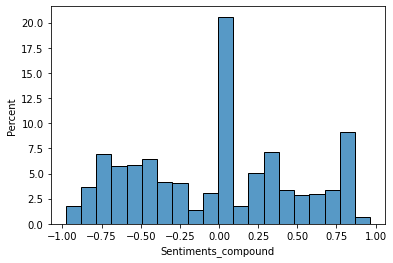

In [95]:
fig = sns.histplot(df, x = 'Sentiments_compound', stat = 'percent')
fig

In [104]:
# Top Negative Tweets
df = df.sort_values(by = ['Sentiments_compound'], ascending = False)
print('Top 10 Positive Tweets')
print('----------------------------------------')
for i in range(0, 10):
    print('Tweet: ', df.iloc[i]['text'])
    

Negative Tweets
----------------------------------------
Tweet:  Create good paying jobs Americans supporting clean energy standard national climate bank clean energy tax credits Justice budget reconciliation turning point climate action
Tweet:  One terrific reason achieve best economic justice fair housing climate justice gun reform racial justice white progressives liberals take cue Black women better
Tweet:  right healthy environment rights clean air safe climate healthy sustainably produced food access safe water adequate sanitation environments live work play healthy ecosystems biodiversity life necessity
Tweet:  moment Support Justice Initiative clean energy standard climate bank amp clean energy tax credits Let make budget reconciliation turning point climate action
Tweet:  moment Support Justice Initiative clean energy standard greenhouse gas reduction fund amp clean energy tax credits Let make budget reconciliation turning point climate action
Tweet:  perspective observations 

In [105]:
# Top Negative Tweets
df = df.sort_values(by = ['Sentiments_compound'])
print('Top 10 Negative Tweets')
print('----------------------------------------')
for i in range(0, 10):
    print('Tweet: ', df.iloc[i]['text'])


Top 10 Negative Tweets
----------------------------------------
Tweet:  climate change cult hates rejects belief hate church hate bible FURIOUS mortal enemy Christians pose biggest threat fraud God created Earth made atmosphere fix time
Tweet:  plot Trump double check questionable votes ignore terror citizens BLM Antifa committed year real threat democracy fuck lying climate change causing tornado Kentucky sad piece shit
Tweet:  Liberals use deadly tornados attack Republicans climate change Liberals attack attack attack Liberal Progressive bitter cruel selfishusing every opportunity attack others
Tweet:  Liberals use deadly tornados attack Republicans climate change Liberals attack attack attack Liberal Progressive bitter cruel selfishusing every opportunity attack others
Tweet:  disgusting limit level sink justify climate bullshit People killed Thousands thousands losing jobs Disgusting
Tweet:  Dont believe climate freaks Worst US may dead may dead StLous illin missori apr SDkota Tex 